# Recurrent Neural Networks

RNNs are a family of neural networks for processing sequential data. 

We have seen how convolutional neural networks are specialized in processing a grid of values $X$. In the same way, RNNs are specialized in processing a sequence of values $x^{(1)}, x^{(2)}, \dots, x^{(\tau)}$. 

To go from MLP to RNN, we again need to take advantage of parameter sharing so that we can process sequences of arbitrary length (just like we did with CNNs for images of arbitrary size). In other words, if we used an MLP, the input layer has a fixed dimensionality, which we do not want. Some sequences may be shorter or longer than other sequences. 

Of course, we could use a 1-D convolution operation on a sequence of data, for which parameter sharing is still applied and this approach is scalable to arbitrary sequence lengths. This is actually the basis for [time-delay networks](https://en.wikipedia.org/wiki/Time_delay_neural_network). However, this type of parameter sharing is not the same as that of RNNs. Using a 1-D convolution means that the output is a product of the input and a small neighbourhood around the input at each time point of the sequence. RNNs instead compute the output based on every single input that came before a specific time step. 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Sequential models

Before delving into RNNs, let's specify what we mean by sequence modeling. A very naive approach is to look at the last $\tau$ instances to predict the next instance in the sequence. 

This type of sequence model is called a **Markov chain model**, and mathematically, it is defined as:

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, \dots, y^{(t-\tau-1)}, y^{(t-\tau)})$

In other words, it models the probability of an output $y$ at time step $t+1$ based on all previous $y$ outputs from time step $t$ to $t-\tau$.

For example, if $\tau = 3$, we get

$P(y^{(t+1)} \;|\; y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)})$

- The conditioning set $\{y^{(t)}, y^{(t-1)}, y^{(t-2)}, y^{(t-3)}\}$ of this probability can be seen as the **input** to our model. 
- The value we are calculating the probability over, i.e., $y^{(t+1)}$ can be seen as the **output** of our model.
- The probability function itself can be seen as the **model** we are attempting to approximate. 

Since our inputs and output always have a fixed length, we can use a linear regression model to predict the relationship between inputs and output.  

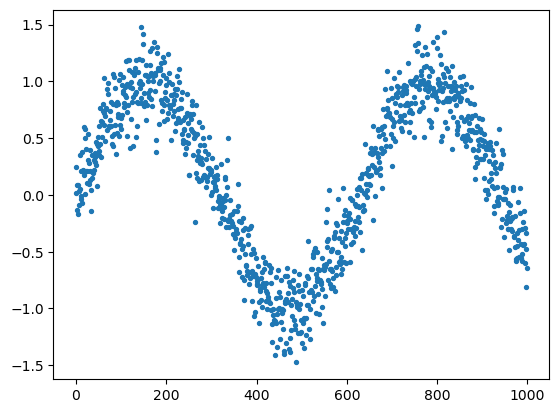

In [2]:
# let's generate a sine wave sequence with a bit of noise
N = 1000
x = torch.arange(0, N, 1)
y = torch.sin(0.01 * x) + torch.normal(0, 1, size=(N,)) * 0.2

plt.scatter(x, y, s=8)

Here, we implement our own linear regression model using PyTorch

In [3]:
from torch.utils.data import DataLoader
from torch.optim import SGD

class LinearRegression(nn.Module):
    def __init__(self, alpha=0.1, batch_size=32, epochs=10, learning_rate=0.01) -> None:
        super().__init__()
        self.alpha = alpha                      # regularization parameter
        self.batch_size = batch_size            # number of batches to process at one time
        self.epochs = epochs                    # number of epochs to train the model
        self.learning_rate = learning_rate      # optimization step size
        self.net = nn.LazyLinear(1)             # simple linear layer
        self.net.weight.data.normal_(0, 0.01)   # initialize weights to be gaussian N(0, 0.01)
        self.net.bias.data.fill_(0)             # initialize bias to be zero
        self.criterion = nn.MSELoss()           # loss criterion is MSE
        self.losses = None
    
    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return self.criterion(y_hat, y)
    
    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.losses = []
        
        # weight_decay parameter ensures regularization, meaning the magnitude of the weight is contrained to be small
        optim = SGD(self.net.parameters(), self.learning_rate, weight_decay=self.alpha)

        # create simple training set
        training_set = torch.cat([X, y.reshape(-1, 1)], dim=1)
        train_dataloader = DataLoader(training_set, self.batch_size, shuffle=True)

        for _ in range(self.epochs):
            
            batch_loss = []
            for batch in train_dataloader:
                # last column is the output
                train_X = batch[:, :-1]
                train_y = batch[:, -1].reshape(-1, 1)

                y_hat = self.net(train_X)

                loss = self.loss(y_hat, train_y)
                batch_loss.append(loss.item())

                # optimization step
                loss.backward()
                optim.step()
                optim.zero_grad()
                
            self.losses.append(sum(batch_loss) / len(batch_loss))

        return self

Using a linear regression we can model a sequence with the length of the context history $\tau=3$

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


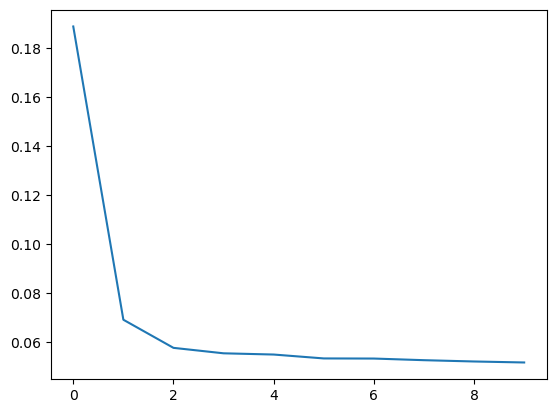

In [4]:
tau = 3
# we take a sliding window over the dataset and create samples of inputs to the model
x_train = torch.cat([y[i : i + tau][None, :] for i in range(N-tau)], dim=0)
y_train = torch.cat([y[i+tau][None] for i in range(N-tau)])

# create and fit model
model = LinearRegression(batch_size=16, epochs=10)
model.fit(x_train, y_train)

plt.plot(model.losses)

We can see that looking 1 step into the future leads to a good model

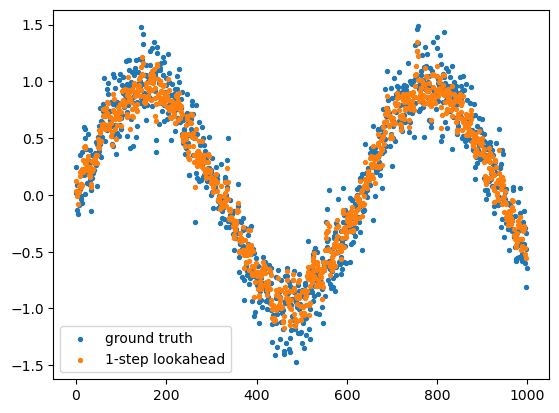

In [5]:
y_pred = model(x_train)
plt.scatter(x, y, s=8, label='ground truth')
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8, label='1-step lookahead')
plt.legend()

However, a big problem is that looking further into the future leads to accumulation of cumulative error, which causes very bad predictions.

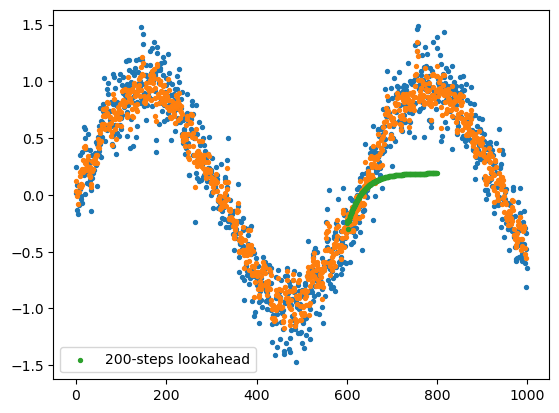

In [6]:
def look_k_steps_into_future(model, k, tau, x_instance):
    # concatenate predictions to make the next predictions
    for _ in range(k-tau):
        y_pred = model(x_instance[-tau:]).detach()
        x_instance = torch.cat([x_instance, y_pred])
    return x_instance

start = 600
steps = 200
future_preds = look_k_steps_into_future(model, steps, tau, x_train[start])

plt.scatter(x, y, s=8)
plt.scatter(range(N-tau), y_pred.detach().numpy(), s=8)
plt.scatter(range(start, start+steps), future_preds, s=8, label=f'{steps}-steps lookahead')
plt.legend()

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\;\textbf{h}^{(t-1)} + \textbf{U}\;\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \hat{\textbf{y}}^{(t)} &= \textbf{c} + \textbf{V}\;\textbf{h}^{(t)}
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

PyTorch handles the mathematics in an efficient way. In the following we define a custom torch module that contains the RNN as well as a linear layer followed by a softmax layer. This allows us to output a distribution of possible outputs for each sequence.   

In [7]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.rnn = nn.RNN(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.rnn(X, H)
        return self.out_layer(output), H

In [8]:
rnn = MyRNN(
    num_inputs=1,
    num_hidden=20,
    num_outputs=5,
    n_layers=3
)

batch_size, seq_len, n_inputs = 32, 50, 1
x = torch.randn(batch_size, seq_len, n_inputs)

y, h = rnn(x)

x.shape, y.shape, h.shape

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([32, 50, 1]), torch.Size([32, 50, 5]), torch.Size([3, 32, 20]))

## Sequence Dataset

Since we operate on sequences when using RNNs, we will be using a dataset where the data is ordered sequentially. 

Specifically, to showcase how to use RNNs, we will use a simple noisy sine wave as our time series. We denote the sequence length of the input sequence by $\tau$. 

- `src_X`: source input covariate sequence (simple enumeration for now $[\textbf{x}^{(0)}, \textbf{x}^{(1)}, \dots, \textbf{x}^{(T)}]$)

- `src_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)}]$)

- `tgt_X`: source target covariate sequence (simple enumeration for now $[\textbf{x}^{(T+1)}, \textbf{x}^{(T+2)}, \dots, \textbf{x}^{(T+\tau)}]$)

- `tgt_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(T+1)}, \textbf{y}^{(T+2)}, \dots, \textbf{y}^{(T+\tau)}]$)

Our learning problem becomes the following: 

Given `src_fX`, we want to predict `tgt_fX`, or in other words:
$$
    [\hat{\textbf{y}}^{(T)}, \hat{\textbf{y}}^{(T+1)}, \dots, \hat{\textbf{y}}^{(T+\tau)}] = \text{RNN}(\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)})
$$

Of course, a more sophisticated sequence model would consider both `src_X` and `src_fX` by aggregating these vectors and feeding it in the model. However, for simplicity, we will only use the feature sequence and only predict the feature sequence. 

In [9]:
from torch.utils.data import Dataset

# base class for an arbitrary sequence dataset
# key idea: samples are generated by sliding window over the entire sequence
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        X: torch.Tensor,
        fX: torch.Tensor,
        seq_len: int,
        shift: int
    ):
        """
        :param X: time steps (covariates)
        :param fX: features per time step
        :param seq_len: length of each sequence example in dataset
        :param shift: number of steps to shift the target values
        """
        self.seq_len = seq_len
        self.shift = shift
        self.X = X
        self.fX = fX

    def __getitem__(self, index):

        sample = (
            self.X[index : index + self.seq_len],
            self.fX[index : index + self.seq_len],
            self.X[index + self.seq_len : index + self.seq_len + self.shift],
            self.fX[index + self.seq_len : index + self.seq_len + self.shift],
        )
        return sample

    def __len__(self):
        return len(self.X) - self.seq_len - self.shift

In [125]:
# specific time series dataset of a noisy sine wave  
class SineSyntheticDataset(TimeSeriesDataset):
    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        alpha: float = 0.1,
        noise: float = 0.1
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)
        fX = torch.sin(alpha * X) + torch.randn_like(X) * noise
        super().__init__(X, fX, seq_len, shift)

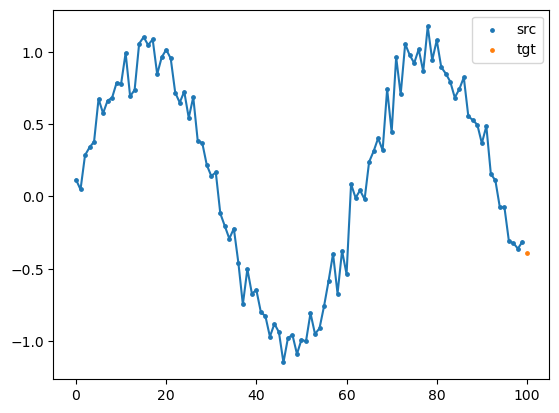

In [106]:
# let's test our dataset
dataset = SineSyntheticDataset(
    len_timeseries=5000, 
    seq_len=100,
    shift=1,
    alpha=0.1,
    noise=0.1
)

src_x, src_fx, tgt_x, tgt_fx = dataset[0]

plt.scatter(src_x, src_fx, s=6, label='src')
plt.plot(src_x, src_fx)
plt.scatter(tgt_x, tgt_fx, s=6, label='tgt')
plt.legend()

## Define train and validation steps

It is good practice to encapsulate a single training and validation step in their own separate functions. 

Notice the differences between train/valid steps:
- `train_step` trains for a single epoch over a given dataloader, where the optimizer is used to perform gradient descent. Additionally, the gradients are clipped as to ensure that gradients do not explode. 
- `valid_step` validates for a single epoch over a given dataloader, without optimizer and within a `no_grad()` context so that no gradients are calculated. 

We use the MSE loss in this case to make single point predictions. The MSE loss implicitly regularizes the predictions such that the predictions converge to the mean prediction. In the case of volatile time series, the MSE loss may not be desired, due to the large variance of the volatility in the sequences. The MSE loss converges to the mean, meaning that predictions will deviate too much from the target. Instead, the Mean Absolute Error (MAE) could pose as an alternative, because the MAE converges to the median (instead of the mean). The median is a reliable averaging metric in situations where there are a lot of outliers (e.g., in volatile time series). 

If the desired output instead should be probabilistic, then we need to predict an interval. In this case, we can use Quantile loss, where we predict different percentiles of the output. Common quantiles are `[0.1, 0.5, 0.9]`, which means that we predict the $10\%$, $50\%$, $90\%$ quantiles. This is a nice option, as it provides some interpretability with respect to how much the model is certain about its predictions. Also notice that the $50\%$ quantile is the same as the median, i.e., it is the same as the MAE.

In the following, we simply use the MSE loss. 

In [107]:
from torch.utils.data import DataLoader

def train_step(
        model: nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim,
        shift: int, 
        device: torch.device,
        grad_clip_val: int = 1
    ):
    model.train()
    batch_loss = []
    for _, batch_X, _, batch_y in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(batch_X)
        loss = F.mse_loss(y_pred[:, -shift:], batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
        optimizer.step()

        batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

def valid_step(
        model: nn.Module, 
        dataloader: DataLoader,
        shift: int, 
        device: torch.device,
    ):
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for _, batch_X, _, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            y_pred, _ = model(batch_X)
            loss = F.mse_loss(y_pred[:, -shift:], batch_y)

            batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

## Setup + train loop

Let's define some constants 

In [109]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 20
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

We create a synthetic sine wave dataset with some added noise. We split this time series in 3 parts, i.e., training part, validation part, and test part. 

- `train_set` consists of the first 80 percent of the time series and will be used to optimize our model
- `valid_set` consists of the next 10 percent of the time series and will be used to monitor whether the model is over/underfitting
- `test_set` consists of the last 10 percent of the time series and will be used to test the model **once** after training has finished. We will also use this set for predictions.

In [111]:
from torch.utils.data import DataLoader

dataset = SineSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    alpha=0.1,
    noise=0.1
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Let's train the model and plot the loss curves

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch=0	train_loss=0.3881729913334693	valid_loss=0.2784332590443747
epoch=1	train_loss=0.173774108050331	valid_loss=0.10117730072566442
epoch=2	train_loss=0.05429552107929222	valid_loss=0.014144871117813247
epoch=3	train_loss=0.015039623820132787	valid_loss=0.01383878437003919
epoch=4	train_loss=0.01470118468146651	valid_loss=0.013227652226175581
epoch=5	train_loss=0.014242873572173619	valid_loss=0.013042822613247804
epoch=6	train_loss=0.013910744804888964	valid_loss=0.013150196788566453
epoch=7	train_loss=0.013714655332507627	valid_loss=0.01281980997217553
epoch=8	train_loss=0.013628929222543393	valid_loss=0.013072724720197064
epoch=9	train_loss=0.013448145781313219	valid_loss=0.012113118012036597
epoch=10	train_loss=0.013291578184092236	valid_loss=0.012115475056426865
epoch=11	train_loss=0.013204770726001552	valid_loss=0.011786912967051779
epoch=12	train_loss=0.013006476099572836	valid_loss=0.011993672432644027
epoch=13	train_loss=0.012853103209166758	valid_loss=0.011544889371309961


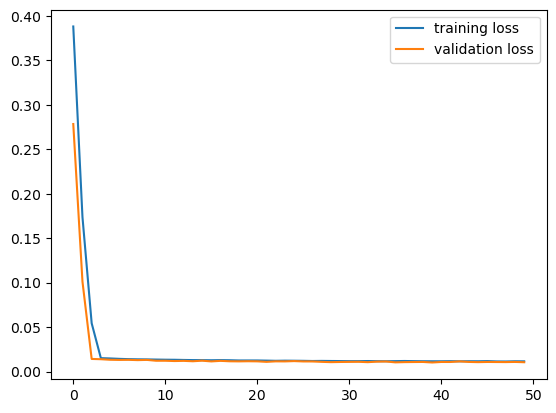

In [112]:
rnn = MyRNN(
    num_inputs=1, 
    num_hidden=N_HIDDEN,
    num_outputs=1, 
    n_layers=N_LAYERS,
    dropout=DROPOUT_RATE, 
).to(DEVICE)

optim = torch.optim.Adam(rnn.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    train_loss = train_step(rnn, train_dataloader, optim, SHIFT, DEVICE)
    train_losses.append(train_loss)
    
    valid_loss = valid_step(rnn, valid_dataloader, SHIFT, DEVICE)
    valid_losses.append(valid_loss)

    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_losses, label="validation loss")
plt.legend()

Since the RNN model takes a sequence as its input and outputs the next value, we can make auto-regressive predictions. This means that we take the prediction and concatenate it to our input 

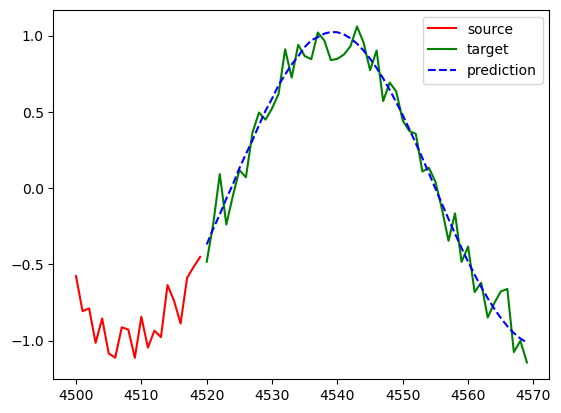

In [117]:
idx = 0
horizon = 50

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]

output = src_fx.flatten().tolist()
tgt_X, tgt_fX = [], []


with torch.no_grad():

    for i in range(horizon):
        
        _, _, tgt_x, tgt_fx = test_set[idx+i]

        output_window = torch.tensor(output[-SEQ_LEN:]).reshape(-1, 1)
        y_pred, _ = rnn(output_window.to(DEVICE))
        output.append(y_pred[-1].item())
        tgt_X.append(tgt_x.item())
        tgt_fX.append(tgt_fx.item())

plt.plot(src_x, src_fx, 'r', label='source')
plt.plot(tgt_X, tgt_fX, 'g', label='target')
plt.plot(tgt_X, output[len(src_fx):], '--b', label='prediction')
plt.legend()

# Long Short-Term Memory (LSTM)

The original RNN model suffers from so-called ``Long-Term Dependencies''. The basic problem is that given a long sequence, the gradients of the model parameters of this sequence tend to either vanish (most of the time) or explode (rarely, but with much damage to the optimization process). Vanishing/exploding gradients occur because the (simplified) recurrence relationship $\mathbf{h}^{(t)} = \mathbf{W}\; \mathbf{h}^{(t-1)}$ is applied many times in longer sequences. As a result, in the unfolded RNN, many multiplication operations are performed. This leads to again many multiplications during backpropagation. 

Now if we consider a value $w$ which is between zero and one, then in the limit $w^n \rightarrow 0$ as $n$ approaches $\infty$. If instead $w > 1$, then in the limit $w^n \rightarrow \infty$ as $n$ approaches $\infty$. This is precisely where both the vanishing/exploding gradients come from. This problem is particular to RNNs because of this recurrence relationship where we multiply the same weights by itself.  

Even if we assume that the parameters of the RNN are learned to be stable (with gradients not vanishing nor exploding), the difficulty of long-term dependencies arises from the exponentially smaller weights given to long-term interactions. As a result, in the forward pass, more weight is given to short-term dependencies, which may be detrimental when the sequence should attend to long-term dependencies.  

Some of these issues can be resolved by using **Gated RNNs**. These include the **Long Short-Term Memory (LSTM)** and the **Gated Recurrent Unit (GRU)**. For now let's consider the LSTM. The main idea is to introduce gates into the RNN similar to electrical gates that regulate the amount of voltage that is able to flow. This gating mechanism is also referred to as a *Leaky unit* (as the gate may leak a bit of information to the future). LSTM uses 3 gates, i.e., input, output, and forget gates. 
- **Input gate** decides what values of the hidden state to update
- **Output gate** decides what the new hidden state will be
- **Forget gate** decides what information to throw away (forget)

Let's see how we can implement the LSTM in PyTorch

In [118]:
class MyLSTM(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.lstm = nn.LSTM(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.lstm(X, H)
        return self.out_layer(output), H

## Applying LSTM on simple noisy sine wave

Let's define some constants

In [ ]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 20
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Same as before, we create a synthetic sine wave dataset with some added noise. We split this time series in 3 parts, i.e., training part, validation part, and test part. 

- `train_set` consists of the first 80 percent of the time series and will be used to optimize our model
- `valid_set` consists of the next 10 percent of the time series and will be used to monitor whether the model is over/underfitting
- `test_set` consists of the last 10 percent of the time series and will be used to test the model **once** after training has finished. We will also use this set for predictions.

In [119]:
from torch.utils.data import DataLoader

dataset = SineSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    alpha=0.1, 
    noise=0.1
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Again, we train the model and monitor/plot the loss curves

epoch=0	train_loss=0.4991023468394433	valid_loss=0.46921312383243013
epoch=1	train_loss=0.43785482500830003	valid_loss=0.39875729169164387
epoch=2	train_loss=0.3340258677640269	valid_loss=0.2638951029096331
epoch=3	train_loss=0.2167991053673529	valid_loss=0.17483660578727722
epoch=4	train_loss=0.11713513281316526	valid_loss=0.042335728981665204
epoch=5	train_loss=0.018379885658261277	valid_loss=0.01420354177909238
epoch=6	train_loss=0.01348407479423669	valid_loss=0.014916739027415003
epoch=7	train_loss=0.013247634794923567	valid_loss=0.014084937183984689
epoch=8	train_loss=0.012841470975188478	valid_loss=0.013601422442921571
epoch=9	train_loss=0.01289253892196763	valid_loss=0.013699933221297604
epoch=10	train_loss=0.012752409919255202	valid_loss=0.013446204630391938
epoch=11	train_loss=0.012632736335358313	valid_loss=0.012634668499231339
epoch=12	train_loss=0.012566196687159038	valid_loss=0.013178229598062379
epoch=13	train_loss=0.012582387805225389	valid_loss=0.013590555505028792
epoc

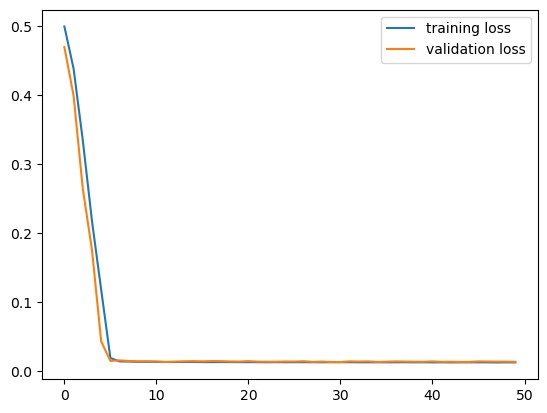

In [120]:
lstm = MyLSTM(
    num_inputs=1, 
    num_hidden=N_HIDDEN,
    num_outputs=1, 
    n_layers=N_LAYERS,
    dropout=DROPOUT_RATE, 
).to(DEVICE)

optim = torch.optim.Adam(lstm.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    train_loss = train_step(lstm, train_dataloader, optim, SHIFT, DEVICE)
    train_losses.append(train_loss)
    
    valid_loss = valid_step(lstm, valid_dataloader, SHIFT, DEVICE)
    valid_losses.append(valid_loss)

    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_losses, label="validation loss")
plt.legend()

Let's make some auto-regressive predictions

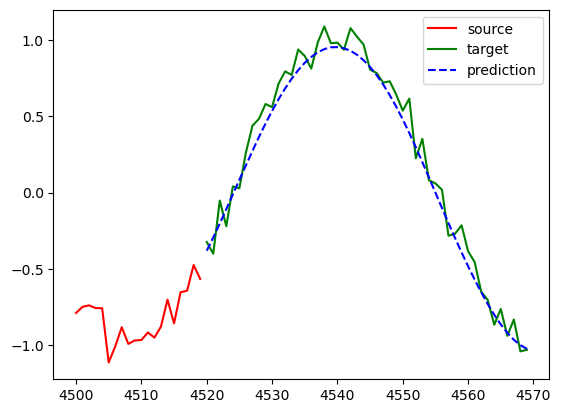

In [122]:
idx = 0
horizon = 50

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]

output = src_fx.flatten().tolist()
tgt_X, tgt_fX = [], []


with torch.no_grad():

    for i in range(horizon):
        
        _, _, tgt_x, tgt_fx = test_set[idx+i]

        output_window = torch.tensor(output[-SEQ_LEN:]).reshape(-1, 1)
        y_pred, _ = lstm(output_window.to(DEVICE))
        output.append(y_pred[-1].item())
        tgt_X.append(tgt_x.item())
        tgt_fX.append(tgt_fx.item())

plt.plot(src_x, src_fx, 'r', label='source')
plt.plot(tgt_X, tgt_fX, 'g', label='target')
plt.plot(tgt_X, output[len(src_fx):], '--b', label='prediction')
plt.legend()

## Applying LSTM on a periodic curve time series

We re-define some constants

In [153]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 128
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

This dataset is a bit more difficult as it is a combination of multiple sinusoidal functions. 

In [154]:
class PeriodicSyntheticDataset(TimeSeriesDataset):
    """
    :param len_timeseries: total length of entire time series
    :param A1, A2, A3: Control the timeseries periodic curves
    """

    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        noise: float,
        A1: float, A2: float,
        A3: float, A4: float,
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)

        c1 = A1 * torch.sin(torch.pi * X[:12] / 6)
        c2 = A2 * torch.sin(torch.pi * X[12:24] / 6)
        c3 = A3 * torch.sin(torch.pi * X[24:96] / 6)
        c4 = A4 * torch.sin(torch.pi * X[96:120] / 12)

        fX = torch.cat([c1, c2, c3, c4], dim=0)  # concat components
        fX = fX.repeat((len_timeseries + 120) // 120, 1)  # periodic repeats
        fX = fX[:len_timeseries]  # constrain total length
        fX = fX + noise * torch.randn(fX.shape)  # add noise

        super().__init__(X, fX, seq_len, shift)

In [155]:
from torch.utils.data import DataLoader

dataset = PeriodicSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    noise=0.1,
    A1=0.4, A2=0.6, A3=0.03, A4=0.6
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

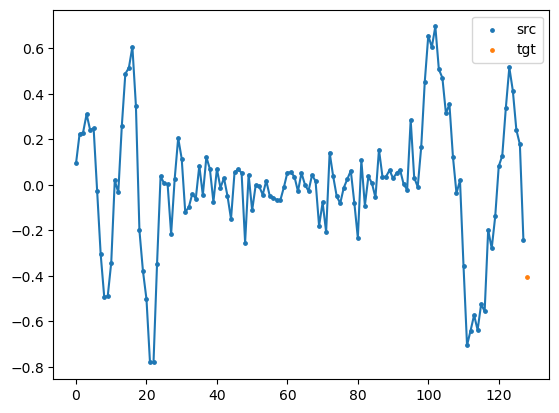

In [156]:
src_x, src_fx, tgt_x, tgt_fx = dataset[0]

plt.scatter(src_x, src_fx, s=6, label='src')
plt.plot(src_x, src_fx)
plt.scatter(tgt_x, tgt_fx, s=6, label='tgt')
plt.legend()

Let's train the model and plot the loss curves

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch=0	train_loss=0.07819536382392529	valid_loss=0.06845868911061968
epoch=1	train_loss=0.07046199283532557	valid_loss=0.06625716175351824
epoch=2	train_loss=0.06769861965890854	valid_loss=0.06031116098165512
epoch=3	train_loss=0.06533805539290752	valid_loss=0.06111608126333782
epoch=4	train_loss=0.062120271876694694	valid_loss=0.05735818775636809
epoch=5	train_loss=0.05859057028447428	valid_loss=0.04644697904586792
epoch=6	train_loss=0.051201885265688744	valid_loss=0.04187821703297751
epoch=7	train_loss=0.042381261565512224	valid_loss=0.036090383040053506
epoch=8	train_loss=0.03598934856633986	valid_loss=0.03059858482863222
epoch=9	train_loss=0.031782460759484	valid_loss=0.029300278584871973
epoch=10	train_loss=0.028706631953677824	valid_loss=0.02622820091034685
epoch=11	train_loss=0.026735060803231694	valid_loss=0.025905059384448186
epoch=12	train_loss=0.02561449154370254	valid_loss=0.025618562740939006
epoch=13	train_loss=0.023799103579574054	valid_loss=0.021885382809809277
epoch=1

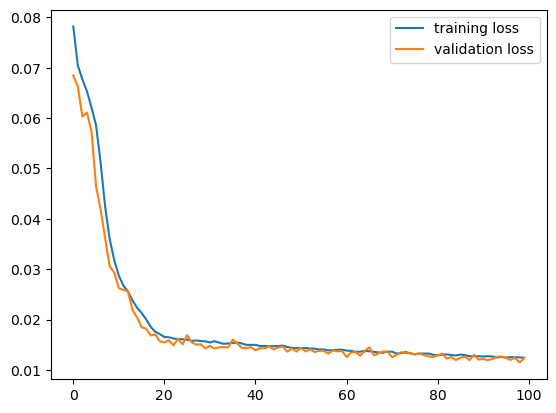

In [157]:
lstm = MyLSTM(
    num_inputs=1, 
    num_hidden=N_HIDDEN,
    num_outputs=1, 
    n_layers=N_LAYERS,
    dropout=DROPOUT_RATE, 
).to(DEVICE)

optim = torch.optim.Adam(lstm.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    train_loss = train_step(lstm, train_dataloader, optim, SHIFT, DEVICE)
    train_losses.append(train_loss)
    
    valid_loss = valid_step(lstm, valid_dataloader, SHIFT, DEVICE)
    valid_losses.append(valid_loss)

    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_losses, label="validation loss")
plt.legend()

In the below, we make auto-regressive predictions where you can see that the model somewhat learned the curving patterns. Since we are using batched SGD, you can see that we are not actively learning the noise, which is nice. 

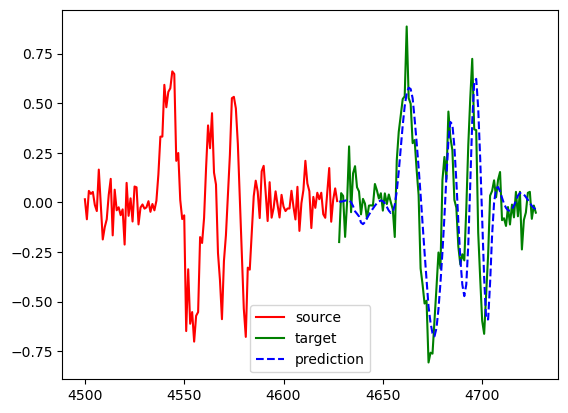

In [158]:
idx = 0
horizon = 100

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]

output = src_fx.flatten().tolist()
tgt_X, tgt_fX = [], []


with torch.no_grad():

    for i in range(horizon):
        
        _, _, tgt_x, tgt_fx = test_set[idx+i]

        output_window = torch.tensor(output[-SEQ_LEN:]).reshape(-1, 1)
        y_pred, _ = lstm(output_window.to(DEVICE))
        output.append(y_pred[-1].item())
        tgt_X.append(tgt_x.item())
        tgt_fX.append(tgt_fx.item())

plt.plot(src_x, src_fx, 'r', label='source')
plt.plot(tgt_X, tgt_fX, 'g', label='target')
plt.plot(tgt_X, output[len(src_fx):], '--b', label='prediction')
plt.legend()